<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 NLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은
<font color = blue>정답 값이 들어올 때 훈련없이 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/NLinear.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['1step-NLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('1step-NLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'1step-NLinear')

['/hdd_1/sjlee/Paper_Project/1step-NLinear']

In [5]:
class Model(nn.Module):
    def __init__(self,configs):
        super(Model,self).__init__()
        self.seq_len = int(configs['1step-NLinear']['seq_len'])
        self.pred_len = int(configs['1step-NLinear']['pred_len'])
        self.channels = int(configs['1step-NLinear']['enc_in'])
        self.individual = configs['1step-NLinear']['individual']
        self.device = torch.device('cuda:0')
        if self.individual == True:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len,self.pred_len)
    
    def forward(self,x):
        # x는 RNN Layer처럼 하나의 값이 하나의 텐서안에 들어가 있도록 즉 (batch_size,sequence_length,channe)
        seq_last = x[:,-1,:].view(-1,1,1) #.detach() 여기서 detach는 의미가 없어 보인다
        print(seq_last)
        # https://bo-10000.tistory.com/181
        x = (x-seq_last)
        seq_last = seq_last.to(self.device)
        if self.individual == True:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype = x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])# 하나의 특성마다 각기 다른 Linear layer에 집어넣어줌
                # 이렇게 인덱싱하면 위에 처럼 linear layer에 넣기 좋게 나온다
            x = output
        else:
            x = self.Linear(x.permute(0,2,1).to(self.device)).permute(0,2,1)
            # Linear layer안에 있는 matrix와 다른 device에 들어있음
        x = x+seq_last
        return x #[Batch, Output length, Channel]

In [6]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)

In [7]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_524293/1396078320.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)


In [8]:
import torch.optim as optim

In [9]:
device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남
device = torch.device("cuda:0")

Adjusting learning rate of group 0 to 1.0000e-05.


In [10]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [11]:
tg

NameError: name 'tg' is not defined

In [13]:
x_seq.permute(0,2,1)

tensor([[[22.0416],
         [22.0480],
         [22.0472],
         ...,
         [22.0650],
         [22.0639],
         [22.0667]],

        [[22.0480],
         [22.0472],
         [22.0424],
         ...,
         [22.0639],
         [22.0667],
         [22.0614]],

        [[22.0472],
         [22.0424],
         [22.0493],
         ...,
         [22.0667],
         [22.0614],
         [22.0653]],

        ...,

        [[22.3283],
         [22.3387],
         [22.3413],
         ...,
         [22.4329],
         [22.4284],
         [22.4437]],

        [[22.3387],
         [22.3413],
         [22.3290],
         ...,
         [22.4284],
         [22.4437],
         [22.4421]],

        [[22.3413],
         [22.3290],
         [22.3190],
         ...,
         [22.4437],
         [22.4421],
         [22.4284]]], device='cuda:0')

In [12]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        out = model(seq.permute(0,2,1))
        
        loss = criterion(out,tg)
       
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

tensor([[[22.0667]],

        [[22.0614]],

        [[22.0653]],

        [[22.0655]],

        [[22.0579]],

        [[22.0694]],

        [[22.0668]],

        [[22.0647]],

        [[22.0688]],

        [[22.0612]],

        [[22.0611]],

        [[22.0699]],

        [[22.0782]],

        [[22.0754]],

        [[22.0722]],

        [[22.0782]],

        [[22.0663]],

        [[22.0683]],

        [[22.0617]],

        [[22.0538]],

        [[22.0519]],

        [[22.0587]],

        [[22.0489]],

        [[22.0542]],

        [[22.0495]],

        [[22.0473]],

        [[22.0506]],

        [[22.0516]],

        [[22.0499]],

        [[22.0498]],

        [[22.0613]],

        [[22.0518]]], device='cuda:0')
tensor([[[22.0565]],

        [[22.0418]],

        [[22.0451]],

        [[22.0545]],

        [[22.0539]],

        [[22.0452]],

        [[22.0525]],

        [[22.0547]],

        [[22.0624]],

        [[22.0532]],

        [[22.0504]],

        [[22.0406]],

        [[22.03

tensor([[[22.4854]],

        [[22.4870]],

        [[22.4819]],

        [[22.4762]],

        [[22.4790]],

        [[22.4870]],

        [[22.4800]],

        [[22.4863]],

        [[22.4772]],

        [[22.4848]],

        [[22.4816]],

        [[22.4902]],

        [[22.4901]],

        [[22.4831]],

        [[22.4759]],

        [[22.4835]],

        [[22.4977]],

        [[22.5110]],

        [[22.4964]],

        [[22.4964]],

        [[22.4551]],

        [[22.4874]],

        [[22.5002]],

        [[22.5118]],

        [[22.5002]],

        [[22.4971]],

        [[22.4950]],

        [[22.5024]],

        [[22.4919]],

        [[22.5013]],

        [[22.4990]],

        [[22.4969]]], device='cuda:0')
tensor([[[22.4954]],

        [[22.4978]],

        [[22.4946]],

        [[22.4959]],

        [[22.4982]],

        [[22.5017]],

        [[22.4946]],

        [[22.4896]],

        [[22.4965]],

        [[22.5010]],

        [[22.5085]],

        [[22.5098]],

        [[22.50

tensor([[[21.9799]],

        [[21.9856]],

        [[21.9852]],

        [[21.9798]],

        [[21.9777]],

        [[21.9826]],

        [[21.9747]],

        [[21.9722]],

        [[21.9691]],

        [[21.9771]],

        [[21.9818]],

        [[21.9783]],

        [[21.9837]],

        [[21.9798]],

        [[21.9773]],

        [[21.9868]],

        [[21.9797]],

        [[21.9894]],

        [[21.9868]],

        [[21.9882]],

        [[21.9889]],

        [[21.9922]],

        [[21.9842]],

        [[21.9905]],

        [[21.9914]],

        [[21.9867]],

        [[21.9887]],

        [[21.9829]],

        [[21.9904]],

        [[21.9849]],

        [[21.9849]],

        [[21.9743]]], device='cuda:0')
tensor([[[21.9760]],

        [[21.9811]],

        [[21.9911]],

        [[21.9944]],

        [[21.9873]],

        [[21.9859]],

        [[21.9899]],

        [[21.9901]],

        [[22.0116]],

        [[21.9985]],

        [[22.0041]],

        [[21.9876]],

        [[21.99

tensor([[[22.4633]],

        [[22.4628]],

        [[22.4680]],

        [[22.4655]],

        [[22.4661]],

        [[22.4673]],

        [[22.4739]],

        [[22.4611]],

        [[22.4548]],

        [[22.4594]],

        [[22.4623]],

        [[22.4598]],

        [[22.4565]],

        [[22.4554]],

        [[22.4503]],

        [[22.4522]],

        [[22.4499]],

        [[22.4492]],

        [[22.4521]],

        [[22.4485]],

        [[22.4476]],

        [[22.4449]],

        [[22.4436]],

        [[22.4469]],

        [[22.4580]],

        [[22.4782]],

        [[22.4734]],

        [[22.4742]],

        [[22.4680]],

        [[22.4570]],

        [[22.4444]],

        [[22.4310]]], device='cuda:0')
tensor([[[22.4324]],

        [[22.4361]],

        [[22.4219]],

        [[22.4257]],

        [[22.4256]],

        [[22.4212]],

        [[22.4238]],

        [[22.4129]],

        [[22.4195]],

        [[22.4173]],

        [[22.4252]],

        [[22.4173]],

        [[22.41

tensor([[[22.0995]],

        [[22.0895]],

        [[22.0875]],

        [[22.0970]],

        [[22.0850]],

        [[22.0926]],

        [[22.0942]],

        [[22.0951]],

        [[22.0941]],

        [[22.1006]],

        [[22.1031]],

        [[22.1037]],

        [[22.0979]],

        [[22.0999]],

        [[22.1005]],

        [[22.1026]],

        [[22.0974]],

        [[22.1151]],

        [[22.1139]],

        [[22.1062]],

        [[22.1110]],

        [[22.1126]],

        [[22.0999]],

        [[22.1118]],

        [[22.1080]],

        [[22.1109]],

        [[22.1080]],

        [[22.1135]],

        [[22.1161]],

        [[22.1073]],

        [[22.1148]],

        [[22.1099]]], device='cuda:0')
tensor([[[22.1266]],

        [[22.1142]],

        [[22.1237]],

        [[22.1255]],

        [[22.1211]],

        [[22.1212]],

        [[22.1260]],

        [[22.1269]],

        [[22.1303]],

        [[22.1291]],

        [[22.1294]],

        [[22.1338]],

        [[22.14

tensor([[[22.2395]],

        [[22.2430]],

        [[22.2352]],

        [[22.2350]],

        [[22.2515]],

        [[22.2282]],

        [[22.2293]],

        [[22.2275]],

        [[22.2234]],

        [[22.2203]],

        [[22.2082]],

        [[22.2019]],

        [[22.2019]],

        [[22.2096]],

        [[22.2068]],

        [[22.2044]],

        [[22.1920]],

        [[22.1954]],

        [[22.1953]],

        [[22.1976]],

        [[22.1905]],

        [[22.2414]],

        [[22.2578]],

        [[22.2385]],

        [[22.2306]],

        [[22.2370]],

        [[22.2359]],

        [[22.2424]],

        [[22.2507]],

        [[22.2504]],

        [[22.2424]],

        [[22.2417]]], device='cuda:0')
tensor([[[22.2507]],

        [[22.2416]],

        [[22.2483]],

        [[22.2427]],

        [[22.2335]],

        [[22.2335]],

        [[22.2373]],

        [[22.2339]],

        [[22.2386]],

        [[22.2294]],

        [[22.2363]],

        [[22.2413]],

        [[22.24

tensor([[[22.4447]],

        [[22.4351]],

        [[22.4449]],

        [[22.4434]],

        [[22.4484]],

        [[22.4535]],

        [[22.4530]],

        [[22.4521]],

        [[22.4512]],

        [[22.4554]],

        [[22.4492]],

        [[22.4536]],

        [[22.4517]],

        [[22.4482]],

        [[22.4418]],

        [[22.4421]],

        [[22.4446]],

        [[22.4439]],

        [[22.4384]],

        [[22.4344]],

        [[22.4335]],

        [[22.4378]],

        [[22.4336]],

        [[22.4464]],

        [[22.4459]],

        [[22.4330]],

        [[22.4410]],

        [[22.4416]],

        [[22.4384]],

        [[22.4317]],

        [[22.4320]],

        [[22.4416]]], device='cuda:0')
tensor([[[22.4341]],

        [[22.4418]],

        [[22.4407]],

        [[22.4402]],

        [[22.4358]],

        [[22.4465]],

        [[22.4510]],

        [[22.4466]],

        [[22.4449]],

        [[22.4401]],

        [[22.4397]],

        [[22.4484]],

        [[22.43

tensor([[[22.0834]],

        [[22.0837]],

        [[22.0820]],

        [[22.0890]],

        [[22.0743]],

        [[22.0792]],

        [[22.0702]],

        [[22.0742]],

        [[22.0734]],

        [[22.0714]],

        [[22.0606]],

        [[22.0617]],

        [[22.0522]],

        [[22.0590]],

        [[22.0751]],

        [[22.0691]],

        [[22.0748]],

        [[22.0704]],

        [[22.0723]],

        [[22.0680]],

        [[22.0683]],

        [[22.0694]],

        [[22.0675]],

        [[22.0732]],

        [[22.0663]],

        [[22.0628]],

        [[22.0640]],

        [[22.0585]],

        [[22.0542]],

        [[22.0579]],

        [[22.0516]],

        [[22.0605]]], device='cuda:0')
tensor([[[22.0632]],

        [[22.0625]],

        [[22.0646]],

        [[22.0633]],

        [[22.0576]],

        [[22.0656]],

        [[22.0617]],

        [[22.0556]],

        [[22.0556]],

        [[22.0598]],

        [[22.0523]],

        [[22.0593]],

        [[22.05

tensor([[[22.7134]],

        [[22.7093]],

        [[22.6994]],

        [[22.7186]],

        [[22.7167]],

        [[22.7148]],

        [[22.7260]],

        [[22.7142]],

        [[22.7146]],

        [[22.7140]],

        [[22.7153]],

        [[22.7114]],

        [[22.7116]],

        [[22.7315]],

        [[22.7303]],

        [[22.7240]],

        [[22.7273]],

        [[22.7161]],

        [[22.7319]],

        [[22.7273]],

        [[22.7324]],

        [[22.7329]],

        [[22.7240]],

        [[22.7401]],

        [[22.7469]],

        [[22.7370]],

        [[22.7211]],

        [[22.7420]],

        [[22.7434]],

        [[22.7431]],

        [[22.7492]],

        [[22.7409]]], device='cuda:0')
tensor([[[22.7516]],

        [[22.7570]],

        [[22.7340]],

        [[22.7409]],

        [[22.7356]],

        [[22.7340]],

        [[22.7463]],

        [[22.7459]],

        [[22.7359]],

        [[22.7428]],

        [[22.7287]],

        [[22.7304]],

        [[22.72

tensor([[[22.2281]],

        [[22.2352]],

        [[22.2192]],

        [[22.2249]],

        [[22.2337]],

        [[22.2370]],

        [[22.2273]],

        [[22.2288]],

        [[22.2249]],

        [[22.2266]],

        [[22.2286]],

        [[22.2210]],

        [[22.2238]],

        [[22.2283]],

        [[22.2331]],

        [[22.2291]],

        [[22.2230]],

        [[22.2341]],

        [[22.2298]],

        [[22.2388]],

        [[22.2223]],

        [[22.2361]],

        [[22.2212]],

        [[22.2389]],

        [[22.2270]],

        [[22.2345]],

        [[22.2268]],

        [[22.2315]],

        [[22.2248]],

        [[22.2283]],

        [[22.2398]],

        [[22.2394]]], device='cuda:0')
tensor([[[22.2327]],

        [[22.2252]],

        [[22.2368]],

        [[22.2260]],

        [[22.2301]],

        [[22.2291]],

        [[22.2320]],

        [[22.2260]],

        [[22.2351]],

        [[22.2349]],

        [[22.2326]],

        [[22.2314]],

        [[22.23

tensor([[[22.7367]],

        [[22.7409]],

        [[22.7440]],

        [[22.7388]],

        [[22.7316]],

        [[22.7405]],

        [[22.7432]],

        [[22.7320]],

        [[22.7281]],

        [[22.7227]],

        [[22.7280]],

        [[22.7317]],

        [[22.7223]],

        [[22.7210]],

        [[22.7244]],

        [[22.7306]],

        [[22.7264]],

        [[22.7094]],

        [[22.7117]],

        [[22.7199]],

        [[22.7248]],

        [[22.7168]],

        [[22.7247]],

        [[22.7167]],

        [[22.7113]],

        [[22.7237]],

        [[22.7198]],

        [[22.7122]],

        [[22.7108]],

        [[22.7203]],

        [[22.7253]],

        [[22.7146]]], device='cuda:0')
tensor([[[22.7074]],

        [[22.7056]],

        [[22.6984]],

        [[22.6979]],

        [[22.7109]],

        [[22.7079]],

        [[22.7076]],

        [[22.7118]],

        [[22.7090]],

        [[22.7067]],

        [[22.6927]],

        [[22.6988]],

        [[22.70

tensor([[[22.3117]],

        [[22.3322]],

        [[22.3238]],

        [[22.3187]],

        [[22.3247]],

        [[22.3177]],

        [[22.3162]],

        [[22.3284]],

        [[22.3251]],

        [[22.3370]],

        [[22.3340]],

        [[22.3241]],

        [[22.3259]],

        [[22.3297]],

        [[22.3255]],

        [[22.3280]],

        [[22.3232]],

        [[22.3337]],

        [[22.3355]],

        [[22.3509]],

        [[22.3396]],

        [[22.3531]],

        [[22.3460]],

        [[22.3532]],

        [[22.3621]],

        [[22.3430]],

        [[22.3438]],

        [[22.3547]],

        [[22.3391]],

        [[22.3422]],

        [[22.3461]],

        [[22.3470]]], device='cuda:0')
tensor([[[22.3462]],

        [[22.3556]],

        [[22.3623]],

        [[22.3667]],

        [[22.3690]],

        [[22.3773]],

        [[22.3797]],

        [[22.3781]],

        [[22.3860]],

        [[22.3845]],

        [[22.3863]],

        [[22.3932]],

        [[22.39

tensor([[[22.4477]],

        [[22.4600]],

        [[22.4691]],

        [[22.4475]],

        [[22.4659]],

        [[22.4651]],

        [[22.4695]],

        [[22.4579]],

        [[22.4638]],

        [[22.4779]],

        [[22.4570]],

        [[22.4594]],

        [[22.4659]],

        [[22.4639]],

        [[22.4514]],

        [[22.4549]],

        [[22.4536]],

        [[22.4494]],

        [[22.4550]],

        [[22.4525]],

        [[22.4503]],

        [[22.4420]],

        [[22.4445]],

        [[22.4440]],

        [[22.4454]],

        [[22.4388]],

        [[22.4514]],

        [[22.4622]],

        [[22.4492]],

        [[22.4558]],

        [[22.4438]],

        [[22.4580]]], device='cuda:0')
tensor([[[22.4379]],

        [[22.4477]],

        [[22.4535]],

        [[22.4649]],

        [[22.4464]],

        [[22.4433]],

        [[22.4464]],

        [[22.4421]],

        [[22.4420]],

        [[22.4454]],

        [[22.4423]],

        [[22.4376]],

        [[22.43

KeyboardInterrupt: 

In [42]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    if idx == 0:
        new_train = torch.FloatTensor(
        [X.iloc[-sequence_length:].values]).view(1,sequence_length,1).to(device)
                
    elif idx < sequence_length:
        new_train = torch.FloatTensor(
            [pd.concat([X.iloc[-sequence_length+idx:],target.iloc[0:idx]],axis=0,ignore_index=True).values]
            ).view(1,sequence_length,1).to(device)
    elif idx >= sequence_length:
        new_train = torch.FloatTensor(
            [target.iloc[idx-sequence_length:idx].values]
            ).view(1,sequence_length,1).to(device)

    with torch.no_grad():
        model.eval()
        out = model(new_train).to(device) # 예측완료
        end = time.time()
        pred_list.append(out.cpu().view(1).item())
        time_list.append(end-start)

<font color = blue> with torch.no_grad()와 model.eval()의 차이</font>
with torch.no_grad() pytorch는 autograd engine을 꺼버리고 이말은 gradient를 계산하지 않는 다는 의미이다 그렇다면 loss.backward()를 하지 않으면 gradient를 계산하든지 말든지 상관이 없다는 말인데 맞는 말이다 이는 단지 속도를 올리기 위해서 감싸는 것이다
그렇다면 model.eval()은 어디에 쓰는 것인가 model.eval()의 목표 몇몇 모델이 training과 inference를 다르게 동작하는 경우가 있기때문에 inference mode로 바꿔주는데 있다

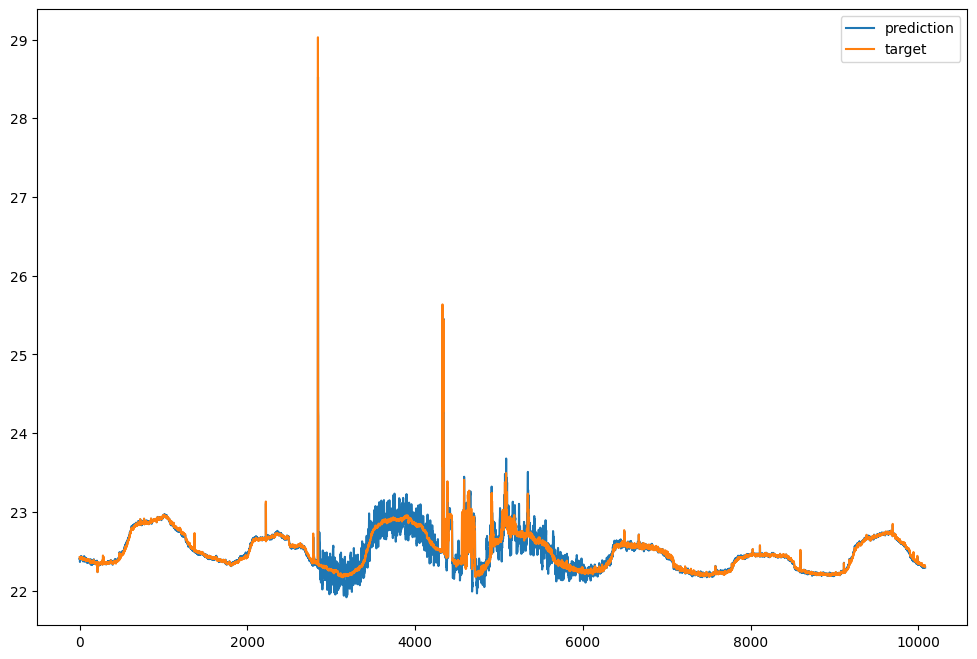

In [44]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [45]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.20362727344036102 %


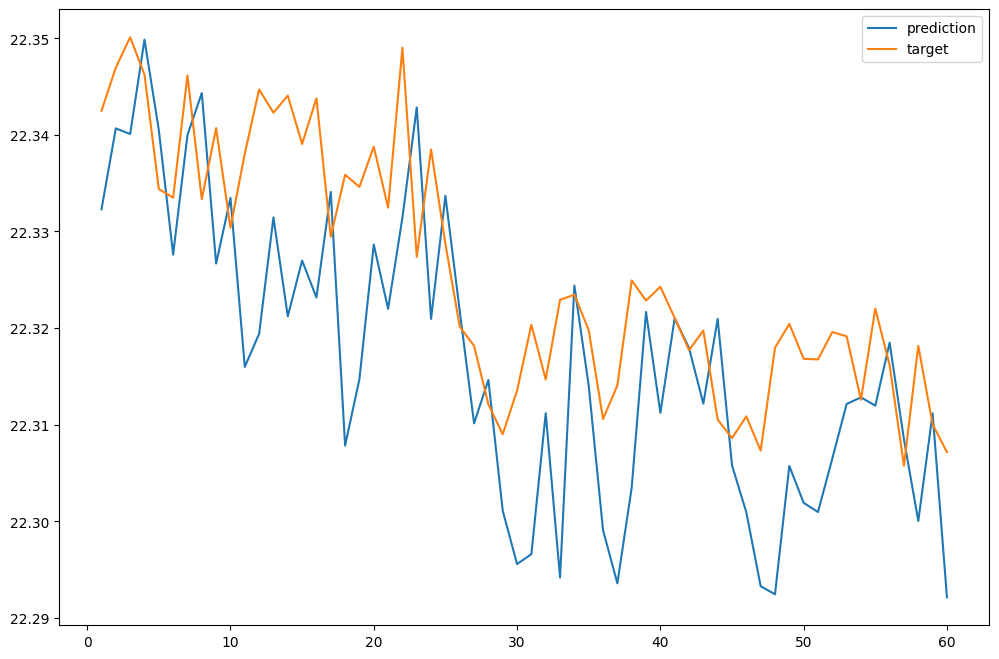

In [46]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()